# YamboConvergence: automated G0W0 convergence

The highest-level workflow is represented by the ``YamboConvergence`` workchain, 
which implements the full automation of the convergence algorithm described in [Bonacci, M., Qiao, J., Spallanzani, N. et al. Towards high-throughput many-body perturbation theory: efficient algorithms and automated workflows. npj Comput Mater 9, 74 (2023)](https://doi.org/10.1038/s41524-023-01027-2). 
Simulations are organized on the fly, without any external user intervention. 
The purpose of this new proposed convergence algorithm is to obtain an accurate converged 
result doing the least possible number of calculations. This is possible if a reliable description of the convergence space is achieved, resulting also in a 
precise guess for the converged point, i.e. the converged parameters. The description of the space is performed by fitting some calculations that the workchain runs. 
A simple functional form of the space is assumed:

$f(\textbf{x}) = \prod_i^N \left( \frac{A_i}{x_i^{\alpha_i}} + b_i \right)$

In this way it is straightforward to compute first and second mixed derivatives, and impose constraints on them to find the converged region of the space. 
The algorithm is specifically designed to solve the coupled convergence between 
summation over empty states (``BndsRnXp`` or ``BndsRnXs`` and ``GbndRnge`` for example) and PW expansion (``NGsBlkXp`` or ``NGsBlkXs``), but it can be used also to 
accelerate convergence tests with respect to the ``k-point mesh`` or ``FFTGvecs``, as we shall see later.

Each simulation is performed by calling the `YamboWorkflow` workchain, ensuring the automation at all levels.


### Example of workflow results:
The successful workflow will return the results of the convergence iterations, as well as a final converged calculation, from which we can parse the
converged parameters (they can be also found in the `infos` outputs of the workflow), and a complete story of all the calculations of the workflow with all the information provided.

To show how the convergence algorithm works, here we plot the convergences performed on 2D-hBN imposing a convergence threshold of 1% on the final gap. The convergence is 
performed with respect to ``NGsBlkXp`` (G_cut in the plot) and ``BndsRnXp`` = ``GbndRnge`` (Nb in the plot). 

![2D_hBN_conv](./images/2D_conv_hBN.png)

We can observe that first simulations (which are the black squares) are performed on a starting grid, the blue one. The algorithm decides then to perform another set of calculations on 
a shifted grid, as the fit was not accurate enough. Next, a converged point is predicted, corresponding to the blue square, and it is explicitely computed. 
Using also the information on that point, the algorithm understands (recomputing the fit) that a new converged point can be the red one. This is then computed and verified to be the real converged one. In this 
way, convergence is efficiently achieved. 

All the calculations are automatically collected in a group, labeled automatically using the structure formula, or pre-existing if the input 
``builder.group_label`` is provided as Str datatype.

In [1]:
from aiida import orm, load_profile
load_profile()

from aiida.plugins import WorkflowFactory
from aiida.orm import QueryBuilder

from aiida_quantumespresso.common.types import ElectronicType

import yaml


qb = QueryBuilder()
qb.append(orm.Group, filters={'label': 'Silicon/bulk'}, tag='group')
qb.append(orm.StructureData, with_group='group')

loaded_structure_id = qb.all()[0][0].pk

# Read YAML file
with open("../configuration/codes_localhost.yaml", 'r') as stream:
    codes = yaml.safe_load(stream)
    
with open("../configuration/resources_localhost.yaml", 'r') as stream:
    resources = yaml.safe_load(stream)
    
options = {
    'pseudo_family':"PseudoDojo/0.4/PBE/SR/standard/upf",
    'protocol':'fast',
    #'parent_id':274, #not necessary to set; if you want it, take ytheour previously nscf id (pk) to skip the DFT part.
    'structure_id':loaded_structure_id,
}
options.update(codes)

In [2]:
YamboConvergence = WorkflowFactory('yambo.yambo.yamboconvergence')
builder = YamboConvergence.get_builder_from_protocol(
    pw_code = options['pwcode_id'],
    preprocessing_code = options['yamboprecode_id'],
    code = options['yambocode_id'],
    protocol=options['protocol'],
    protocol_qe=options['protocol'],
    structure=orm.load_node(options['structure_id']),
    overrides={},
    #parent_folder=load_node(options['parent_id']).outputs.remote_folder,
    electronic_type=ElectronicType.INSULATOR, #default is METAL: smearing is used
    calc_type='gw', #or 'bse'; default is 'gw'
)

builder.ywfl.scf.pw.metadata.options = resources

builder.ywfl.nscf.pw.metadata.options = builder.ywfl.scf.pw.metadata.options
builder.ywfl.yres.yambo.metadata.options = builder.ywfl.scf.pw.metadata.options

Summary of the main inputs:
BndsRnXp = 150
GbndRnge = 150
NGsBlkXp = 2 Ry
FFTGvecs = 9 Ry


kpoint mesh for nscf: [6, 6, 6]


/home/max/.conda/envs/aiida/lib/python3.9/site-packages/aiida_quantumespresso/calculations/pw.py:211: UserWarning: `parent_folder` not provided for `nscf` calculation. For work chains wrapping this calculation, you can disable this warning by excluding the `parent_folder` when exposing the inputs of the `PwCalculation`.
  warnings.warn(


In [3]:
#You can also try different protocols:
    
YamboConvergence.get_available_protocols()

{'fast': {'description': 'Fast protocol for a GW convergence: grid -> poor; thresholds -> poor'},
 'moderate': {'description': 'Moderate protocol for a GW convergence: grid -> enough good for standard materials; thresholds -> moderate (5 percent)'},
 'precise': {'description': 'precise protocol for a GW convergence: grid -> same as moderate; thresholds -> precise (1 percent)'},
 'molecule': {'description': 'Moderate protocol for a GW convergence in molecules'}}

### Overrides

It is possible to modify the default inputs also during the builder creation phase, so not a posteriori. This can be done by using overrides:

In [4]:
overrides_scf = {
        'pseudo_family': "PseudoDojo/0.4/PBE/SR/standard/upf", 
        'pw':{
            'parameters':{
                'CONTROL':{}, #not needed if you don't override something
                'SYSTEM':{"ecutwfc":70,"ecutrho":70*4},
            },
           'metadata':{"options":resources},
        },
    }

overrides_nscf = {
        'pseudo_family': "PseudoDojo/0.4/PBE/SR/standard/upf", 
        'pw': {
            'parameters':{
                'CONTROL':{}, #not needed if you don't override something
                'SYSTEM':{"ecutwfc":70,"ecutrho":70*4},
                'ELECTRONS':{'diagonalization':'david'},
            },
             'metadata':{"options":resources},
    },
}

overrides_yambo = {
        "yambo": {
            "parameters": {
                "arguments": [
                    "rim_cut",
                ],
                "variables": {
                    "NGsBlkXp": [4, "Ry"],
                    "FFTGvecs": [20, "Ry"],
                },
            },
        'metadata':{"options":resources},
        },
    
}


## providing additional convergence settings

In the following we provide additional convergence settings, namely:

- 'what': a list of quantities to be computed, following the same naming convention of the `YamboWorkflow` additional parsing list;
- 'type': 'heavy', or 'cheap'; heavy keeps the converged parameters as obtained in previous iterations; for example, if I convergence k-mesh and then bands, in the bands convergence we will use the converged k-mesh. This will make the calculation more and more computational demanding, but in the end we will obtain the true converged results, not only the converged value of the parameters.

In [5]:
overrides_wfl_settings = {
    'what':['gap_'],
    'type': 'heavy', #or cheap; heavy uses converged value for parameters that we are not converging in a given iteration.
    }

the quantities that we can converge are the ones that can be parsed by the 
``YamboWorkflow`` workchain: quasiparticle levels/gaps, and excitonic energies:

* 'gap_': gap as found from nscf calculation (may differ from the final GW band gap, in terms of value and k-point indexes);
* 'gap_GG': gap at the Gamma point;
* 'lowest_exciton': lowest exciton from BSE;
* 'brightest_exciton': brightest exciton from BSE.

In [6]:
#setting the overall overrides dictionary.

overrides = {
    'ywfl':{'scf':overrides_scf,'nscf':overrides_nscf,'yres':overrides_yambo},
    'workflow_settings':overrides_wfl_settings,
    }

In [7]:
builder = YamboConvergence.get_builder_from_protocol(
    pw_code = options['pwcode_id'],
    preprocessing_code = options['yamboprecode_id'],
    code = options['yambocode_id'],
    protocol=options['protocol'],
    protocol_qe=options['protocol'],
    structure= orm.load_node(options['structure_id']),
    overrides=overrides,
    pseudo_family = options["pseudo_family"],
    #parent_folder=load_node(options['parent_id']).outputs.remote_folder,
    electronic_type=ElectronicType.INSULATOR, #default is METAL: smearing is used
    calc_type='gw', #or 'bse'; default is 'gw'
)



Summary of the main inputs:
BndsRnXp = 150
GbndRnge = 150
NGsBlkXp = 4 Ry
FFTGvecs = 20 Ry


kpoint mesh for nscf: [6, 6, 6]


/home/max/.conda/envs/aiida/lib/python3.9/site-packages/aiida_quantumespresso/calculations/pw.py:211: UserWarning: `parent_folder` not provided for `nscf` calculation. For work chains wrapping this calculation, you can disable this warning by excluding the `parent_folder` when exposing the inputs of the `PwCalculation`.
  warnings.warn(


### Inspecting the convergence space:

In [8]:
builder.parameters_space.get_list()

[{'var': ['FFTGvecs'],
  'start': 17,
  'stop': 49,
  'delta': 7,
  'max': 70,
  'steps': 4,
  'max_iterations': 4,
  'conv_thr': 10,
  'conv_thr_units': '%',
  'convergence_algorithm': 'new_algorithm_1D'},
 {'var': ['kpoint_mesh'],
  'start': [4, 4, 4],
  'stop': [12, 12, 12],
  'delta': [1, 1, 1],
  'max': [22, 22, 22],
  'steps': 4,
  'max_iterations': 4,
  'conv_thr': 10,
  'conv_thr_units': '%',
  'convergence_algorithm': 'new_algorithm_1D'},
 {'var': ['BndsRnXp', 'GbndRnge', 'NGsBlkXp'],
  'start': [200, 200, 6],
  'stop': [800, 800, 18],
  'delta': [100, 100, 2],
  'max': [2000, 2000, 40],
  'steps': 6,
  'max_iterations': 8,
  'conv_thr': 10,
  'conv_thr_units': '%',
  'convergence_algorithm': 'new_algorithm_2D'}]

The workflow will follow such a list, from `FFTGvecs`, `kpoint_mesh` and then to `BndsRnXp, GbndRnge, NGsBlkXp`, performing each of the three iterations trying to convergence the corresponding parameters. Please note that the last step (`BndsRnXp, GbndRnge, NGsBlkXp`) will perform the convergence of the coupled parameters *BndsRnXp=GbndRnge* and *NGsBlkXp*. Depending on your system, a good convergence journey would be ['FFTGvecs'] -> ['BndsRnXp', 'GbndRnge', 'NGsBlkXp'] -> ['kpoint_mesh']. 

The number of `steps` for each iteration should be fixed (do not change it):
- new_algorithm_2D -> steps:6
- new_algorithm_1D -> steps:4

We can provide an ad hoc convergence space:

In [9]:
builder.parameters_space=orm.List(
    [{'var': ['FFTGvecs'],
      'start': 21,
      'stop': 58,
      'delta': 8,
      'max': 84,
      'steps': 4,    # Fixed to 4 if convergence_algorithm=new_algorithm_1D
      'max_iterations': 4,
      'conv_thr': 10,
      'conv_thr_units': '%',
      'convergence_algorithm': 'new_algorithm_1D'},   #we are converging 1 parameter
     #{'var': ['kpoint_mesh'],
     # 'start': [4, 4, 2],
     # 'stop': [16, 16, 6],
     # 'delta': [3, 3, 3],
     # 'max': [30, 30, 10],
     # 'steps': 4,
     # 'max_iterations': 4,
     # 'conv_thr': 10,
     # 'conv_thr_units': '%',
     # 'convergence_algorithm': 'new_algorithm_1D'},
     {'var': ['BndsRnXp', 'GbndRnge', 'NGsBlkXp'],
      'start': [50,50,2],                           #starting values
      'stop': [400,400, 8],                          #maximum values for the first grid
      'delta': [50, 50, 1],                           #grid spacing
      'max': [1000, 1000, 16],                          #maximum values for the largest grid possible
      'steps': 6,                                     #steps/calculation per iteration. For ['BndsRnXp', 'GbndRnge', 'NGsBlkXp'], always 6
      'max_iterations': 8,                            #maximum attempts
      'conv_thr': 10,                                 #converge threshold
      'conv_thr_units': '%',                          #converge threshold units: '%' is the relative error with respect to the most converged value; can be also 'eV'
      'convergence_algorithm': 'new_algorithm_2D'}],  #we are converging actually 2 parameters: bands
)

### Parameter-dependent resources

As you can imagine, increasing the parameters of the simulations may require also the change of the related computational resources, in order to be able to successfully perform them. 
Before the submission of the WorkChain, we can provide instructions on how to continously adapt the resources when parameters are changing.

In particular, we provide two dictionaries:
- parallelism instructions
- explicit resources instructions

In [10]:
dict_para_medium = {}
dict_para_medium['X_and_IO_CPU'] = '1 1 1 1 1'
dict_para_medium['X_and_IO_ROLEs'] = 'q k g c v'
dict_para_medium['DIP_CPU'] = '1 1 1'
dict_para_medium['DIP_ROLEs'] = 'k c v'
dict_para_medium['SE_CPU'] = '1 1 1'
dict_para_medium['SE_ROLEs'] = 'q qp b'

dict_res_medium = {
        "num_machines": 1,
        "num_mpiprocs_per_machine":1,
        "num_cores_per_mpiproc":1,
    }

dict_para_high = {}
dict_para_high['X_and_IO_CPU'] = '1 1 1 2 1' 
dict_para_high['X_and_IO_ROLEs'] = 'q k g c v'
dict_para_high['DIP_CPU'] = '1 2 1'
dict_para_high['DIP_ROLEs'] = 'k c v'
dict_para_high['SE_CPU'] = '1 1 2'
dict_para_high['SE_ROLEs'] = 'q qp b'

dict_res_high = {
        "num_machines": 1,
        "num_mpiprocs_per_machine":2,
        "num_cores_per_mpiproc":1,
    }

parallelism_instructions_manual = orm.Dict(dict={'manual' : {                                                            
                                                            'std_1':{
                                                                    'BndsRnXp':[1,100], #range for bands where to use the dict_para_medium and dict_res_medium instructions.
                                                                    'NGsBlkXp':[2,18],
                                                                    'parallelism':dict_para_medium,
                                                                    'resources':dict_res_medium,
                                                                    },
                                                            'std_2':{
                                                                    'BndsRnXp':[101,1000],
                                                                    'NGsBlkXp':[2,18],
                                                                    'parallelism':dict_para_high,
                                                                    'resources':dict_res_high,
                                                                    },}})

We can just provide, together with the resources, the `mode` which yambo will use to automatically set up its parallelism, if we are not sure on how to decide the explicit parallelism instructions.

In [11]:
parallelism_instructions_auto = orm.Dict(dict={'automatic' : {                                                            
                                                            'std_1':{
                                                                    'BndsRnXp':[1,100],
                                                                    'NGsBlkXp':[1,18],
                                                                    'mode':'balanced',
                                                                    'resources':dict_res_medium,
                                                                    },
                                                            'std_2':{
                                                                    'BndsRnXp':[101,1000],
                                                                    'NGsBlkXp':[1,18],
                                                                    'mode':'memory',
                                                                    'resources':dict_res_high,
                                                                    },}})

In [12]:
builder.parallelism_instructions = parallelism_instructions_auto

### Providing an AiiDA group where to collect all the convergence simulations

When `YamboConvergence` is submitted, it automatically creates a group where to put all the simulations. Each time a simulation is ready to be submitted, there is an internal check in the group, to understand
if an identical simulation has been already performed. In that case, the submission is skipped and we reuse the results to perform our analysis. This is a sort of ad-hoc [caching](https://aiida.readthedocs.io/projects/aiida-core/en/latest/topics/provenance/caching.html), which however does not duplicate the involved nodes. 

We prefer to just reuse the results as often even the retrieved files for yambo simulations are large (`ndb.QP` for example).

It is possible also to provide a pre-existing group, by means of the `group_label` input String.

In [13]:
try:
    g = orm.load_group('tutorial/Silicon/convergence/GW')
except:
    g = orm.Group('tutorial/Silicon/convergence/GW')
    g.store()

In [14]:
builder.group_label = orm.Str('tutorial/Silicon/convergence/GW') # verdi group create tutorial/Silicon/convergence; all calculationsc are added to the group

### Run

In [15]:
from aiida.engine import submit

In [16]:
run = None

In [17]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

/home/max/.conda/envs/aiida/lib/python3.9/site-packages/aiida_quantumespresso/calculations/pw.py:211: UserWarning: `parent_folder` not provided for `nscf` calculation. For work chains wrapping this calculation, you can disable this warning by excluding the `parent_folder` when exposing the inputs of the `PwCalculation`.
  warnings.warn(


uuid: a1146632-fefc-49d1-8a36-3bec38239f27 (pk: 890) (aiida.workflows:yambo.yambo.yamboconvergence)


In [24]:
!verdi process report {run.pk}

2024-02-19 15:51:00 [201 | REPORT]: [890|YamboConvergence|start_workflow]: group: tutorial/Silicon/convergence/GW
2024-02-19 15:51:00 [202 | REPORT]: [890|YamboConvergence|start_workflow]: Workflow type: heavy; looking for convergence of ['gap_']
2024-02-19 15:51:00 [203 | REPORT]: [890|YamboConvergence|start_workflow]: Workflow initilization step completed, the parameters will be: ['FFTGvecs'].
2024-02-19 15:51:00 [204 | REPORT]: [890|YamboConvergence|has_to_continue]: Still iteration on ['FFTGvecs']
2024-02-19 15:51:00 [205 | REPORT]: [890|YamboConvergence|pre_needed]: {'FFTGvecs': [21, 37, 45, 58], 'BndsRnXp': [50, 400, 50, 150, 300, 400], 'NGsBlkXp': [2, 2, 8, 6, 4, 8], 'GbndRnge': [50, 400, 50, 150, 300, 400]}
2024-02-19 15:51:00 [206 | REPORT]: [890|YamboConvergence|pre_needed]: ['GW bands are: 150', 'scf inputs found', 'nscf inputs found']
2024-02-19 15:51:00 [207 | REPORT]: [890|YamboConvergence|do_pre]: mesh check
2024-02-19 15:51:00 [208 | REPORT]: [890|YamboConvergence|do_pr

# Output analysis.

suppose that your calculation completed successfully, then you can access the outputs via the output method of the run instance: 

In [25]:
run = orm.load_node(890)

In [26]:
run.is_finished_ok

True

The converged parameters can be obtained via the "infos" output Dict:

In [27]:
run.outputs.infos.get_dict()

{'gap_': 1.1291255631387,
 'E_ref': 1.2629000046475,
 'BndsRnXp': 100.0,
 'FFTGvecs': 21,
 'GbndRnge': 100.0,
 'NGsBlkXp': 5.0,
 'extrapolation': 1.2710088188436}

The full convergence history can be visualized in a table form using pandas:

In [28]:
import pandas as pd

In [29]:
history = run.outputs.history.get_dict()

In [30]:
history_table = pd.DataFrame(history)

In [31]:
history_table

,gap_,uuid,failed,useful,BndsRnXp,FFTGvecs,GbndRnge,NGsBlkXp,global_step,parameters_studied
0,1.052619,86672fa7-1f72-4015-969f-541ae4397d74,False,False,150,21,150,4.0,1,FFTGvecs
1,1.052237,104611a0-dc81-4176-ba36-0325cf036638,False,False,150,37,150,4.0,2,FFTGvecs
2,1.052241,bdae7620-16d8-45ac-8a5f-9853a89b4087,False,False,150,45,150,4.0,3,FFTGvecs
3,1.052227,e9b5696d-545f-4f32-b99e-a0806e42d33e,False,False,150,58,150,4.0,4,FFTGvecs
4,0.921310,38640663-13b0-44a6-8442-6d2c06bb4848,False,False,50,21,50,2.0,5,"BndsRnXp, GbndRnge, NGsBlkXp"
5,0.919394,a0cc1686-6ce2-474b-bc09-43b8d3e35459,False,False,400,21,400,2.0,6,"BndsRnXp, GbndRnge, NGsBlkXp"
6,1.199155,10616881-430a-4dd7-9bf6-ddbfd4aaa433,False,False,50,21,50,8.0,7,"BndsRnXp, GbndRnge, NGsBlkXp"
7,1.131704,17ee124c-5152-46bb-9bac-4caed41e8dc1,False,False,150,21,150,6.0,8,"BndsRnXp, GbndRnge, NGsBlkXp"
8,1.053912,8a7e983d-f690-4bd1-9c55-5763d30115ea,False,False,300,21,300,4.0,9,"BndsRnXp, GbndRnge, NGsBlkXp"
9,1.227951,38ab7c55-3538-4518-a4f6-bb35e4f8af78,False,False,400,21,400,8.0,10,"BndsRnXp, GbndRnge, NGsBlkXp"


The converged calculations can be easily observed using:

In [32]:
history_table[history_table['useful']==True]

,gap_,uuid,failed,useful,BndsRnXp,FFTGvecs,GbndRnge,NGsBlkXp,global_step,parameters_studied
16,1.129126,5e3dd853-4932-4cb8-a023-dc319b4e5e81,False,True,100,21,100,5.0,17,"BndsRnXp, GbndRnge, NGsBlkXp"


Result on the convergence path can be plotted. Here below a code snippet to print our results: 

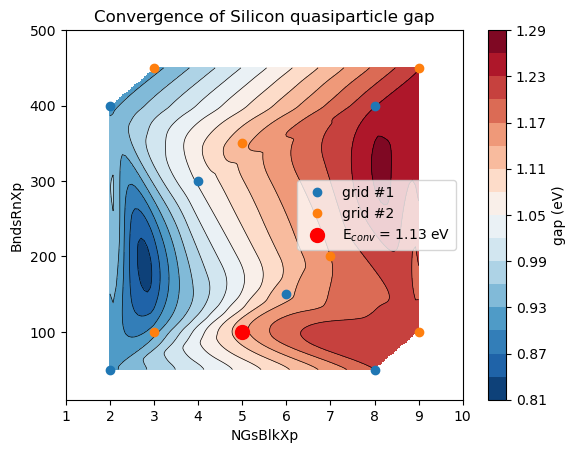

In [82]:
# following: https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html

import matplotlib.pyplot as plt
import numpy as np

b_G_history = history_table[history_table['parameters_studied']=="BndsRnXp, GbndRnge, NGsBlkXp"]

np.random.seed(19680801)
npts = 200
ngridx = 100
ngridy = 200
x = b_G_history.NGsBlkXp
y = b_G_history.BndsRnXp
z = b_G_history.gap_

fig, ax1 = plt.subplots()

# -----------------------
# Interpolation on a grid
# -----------------------
# A contour plot of irregularly spaced data coordinates
# via interpolation on a grid.

# Create grid values first.
xi = np.linspace(2,9, ngridx)
yi = np.linspace(50,450, ngridy)

from scipy.interpolate import griddata
zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='cubic')

ax1.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
cntr1 = ax1.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")

fig.colorbar(cntr1, ax=ax1, label="gap (eV)")
ax1.plot(x[:6], y[:6], 'o', ms=6, label="grid #1")
ax1.plot(x[6:12], y[6:12], 'o', ms=6, label="grid #2")
ax1.plot(x[12], y[12], 'ro', ms=10, label="E$_{conv}$ = "+f"{np.round(z[12],2)} eV")

ax1.set(xlim=(1,10), ylim=(10,500))
ax1.set_title('Convergence of Silicon quasiparticle gap')
ax1.set_xlabel("NGsBlkXp")
ax1.set_ylabel("BndsRnXp")

plt.legend()

The interpolation of the convergence space, as done above, is just for having an idea of the convergence region; indeed, the accuracy of the interpolation is not completly reliable with such few points.